In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

data = pd.read_csv("concrete_data.csv")

data.columns = [
    'Cement', 'Slag', 'FlyAsh', 'Water', 'Superplasticizer',
    'CoarseAgg', 'FineAgg', 'Age', 'Strength'
]


Атрибуты датасета (8 признаков + 1 целевая переменная): 
Cement - Содержание цемента (кг/м³, непрерывный) 
BlastFurnaceSlag - Шлак доменной печи (кг/м³, непрерывный) 
FlyAsh - Зола-унос (кг/м³, непрерывный) 
Water - Вода (кг/м³, непрерывный) 
Superplasticizer - Суперпластификатор (кг/м³, непрерывный) 
CoarseAggregate - Крупный заполнитель (кг/м³, непрерывный) 
FineAggregate - Мелкий заполнитель (кг/м³, непрерывный) 
Age - Возраст образца (дней, непрерывный) 
CompressiveStrength - Прочность на сжатие (МПа, непрерывный, целевая переменная)

In [2]:
# Добавление нового атрибута Water/Cement Ratio
data["water_cement_ratio"] = data["Water"] / data["Cement"]
print(f"Размер данных с новым атрибутом: {data.shape}")


Размер данных с новым атрибутом: (1030, 10)


In [3]:
#Проверка на наличие дубликатов и пропусков, удаление дубликатов
print(f"Количество дубликатов до удаления: {data.duplicated().sum()}")
data = data.drop_duplicates()
print(f"Пропуски: {data.isnull().sum().sum()}")


Количество дубликатов до удаления: 25
Пропуски: 0


In [4]:
print("Выбросы:")
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)}")
    
    # Удаляем выбросы
    data = data[(data[col] >= Q1 - 1.5*IQR) & (data[col] <= Q3 + 1.5*IQR)]

print(f"Размер данных после удаления выбросов: {data.shape}")


Выбросы:
Cement: 0
Slag: 2
FlyAsh: 0
Water: 15
Superplasticizer: 10
CoarseAgg: 0
FineAgg: 0
Age: 59
Strength: 8
water_cement_ratio: 16
Размер данных после удаления выбросов: (895, 10)


In [5]:
numeric_cols = [
    'Cement', 'Slag', 'FlyAsh', 'Water',
    'Superplasticizer', 'CoarseAgg', 'FineAgg', 'Age',
    'water_cement_ratio'
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[numeric_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)
print(f"Размер scaled_df: {scaled_df.shape}")


Размер scaled_df: (895, 9)


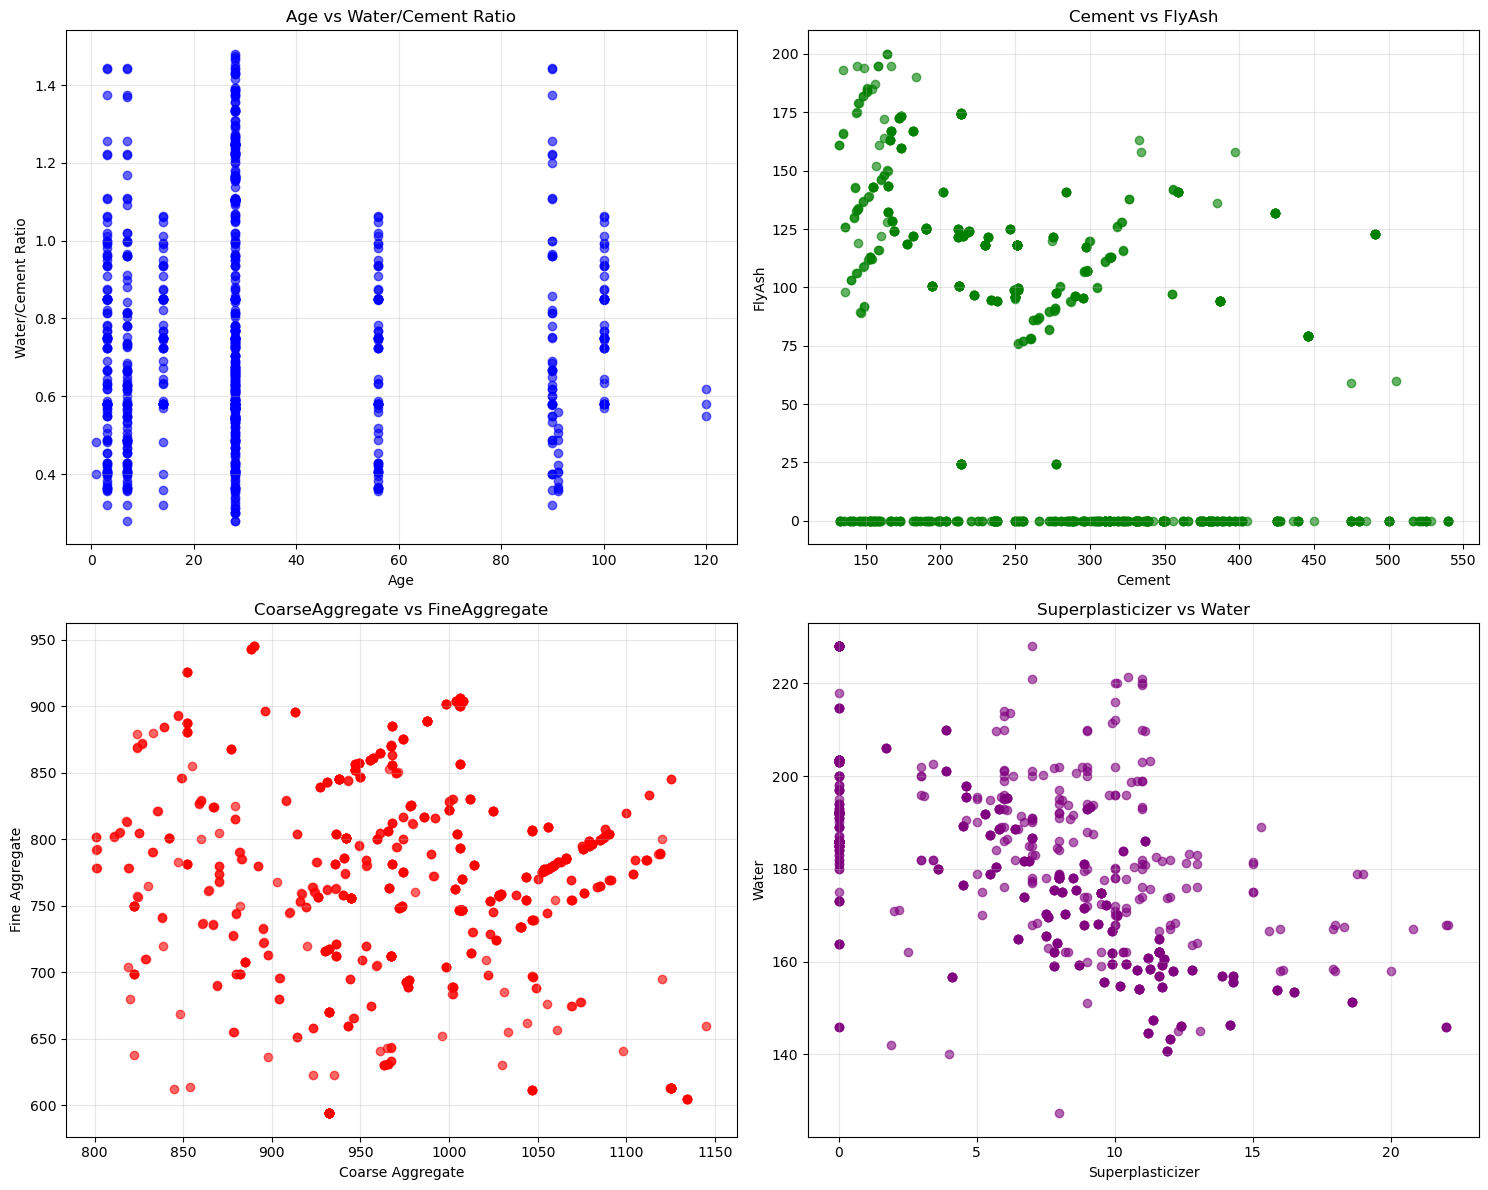

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Age vs Water/Cement Ratio
axes[0,0].scatter(data['Age'], data['water_cement_ratio'], alpha=0.6, c='blue')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Water/Cement Ratio')
axes[0,0].set_title('Age vs Water/Cement Ratio')
axes[0,0].grid(True, alpha=0.3)

# График 2: Cement vs FlyAsh
axes[0,1].scatter(data['Cement'], data['FlyAsh'], alpha=0.6, c='green')
axes[0,1].set_xlabel('Cement')
axes[0,1].set_ylabel('FlyAsh')
axes[0,1].set_title('Cement vs FlyAsh')
axes[0,1].grid(True, alpha=0.3)

# График 3: CoarseAgg vs FineAgg
axes[1,0].scatter(data['CoarseAgg'], data['FineAgg'], alpha=0.6, c='red')
axes[1,0].set_xlabel('Coarse Aggregate')
axes[1,0].set_ylabel('Fine Aggregate')
axes[1,0].set_title('CoarseAggregate vs FineAggregate')
axes[1,0].grid(True, alpha=0.3)

# График 4: Superplasticizer vs Water
axes[1,1].scatter(data['Superplasticizer'], data['Water'], alpha=0.6, c='purple')
axes[1,1].set_xlabel('Superplasticizer')
axes[1,1].set_ylabel('Water')
axes[1,1].set_title('Superplasticizer vs Water')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\chist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\chist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\chist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\chist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

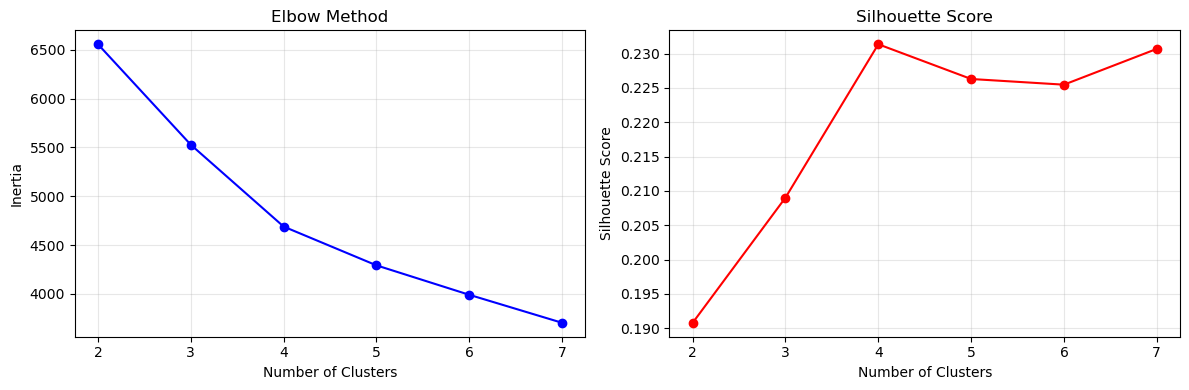

In [7]:
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(range(2, 8), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Оптимальное число кластеров 4, так как:
На графике с методом локтя видна точка замедления, а график с силуэтным анализом достигает максимума при k=4.

In [8]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_df)

data['cluster'] = clusters


C:\Users\chist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


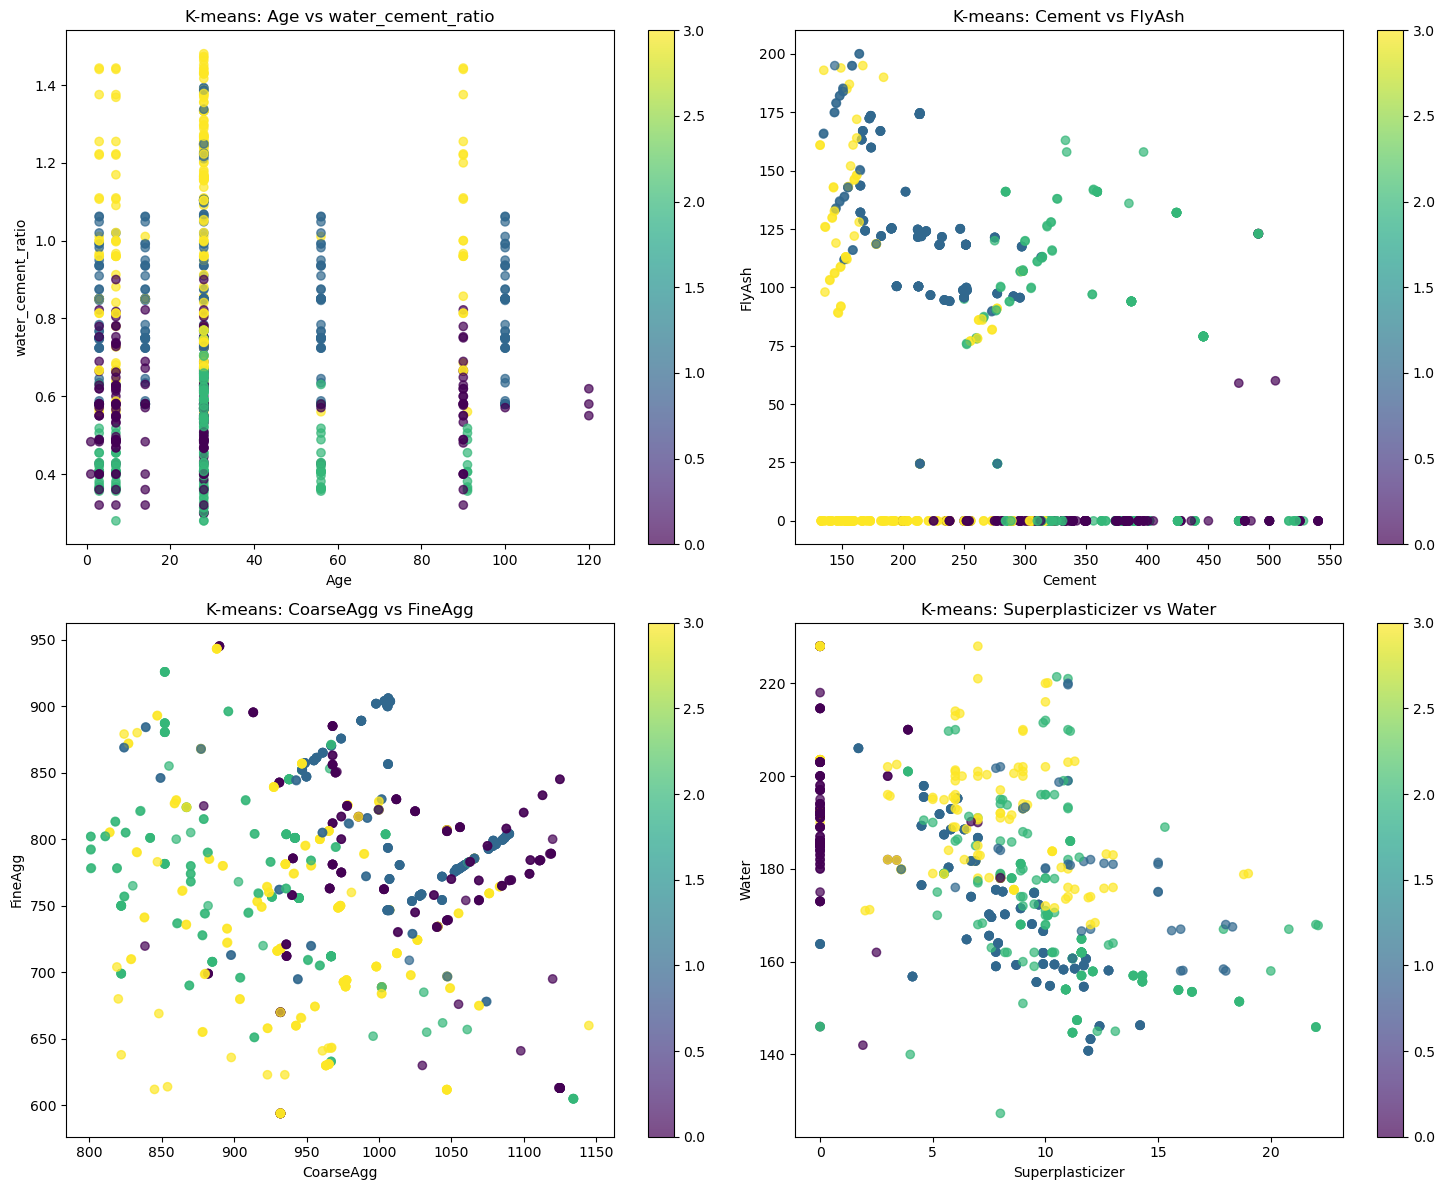

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

scatter1 = axes[0,0].scatter(data['Age'], data['water_cement_ratio'], c=data['cluster'], cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('water_cement_ratio')
axes[0,0].set_title('K-means: Age vs water_cement_ratio')
plt.colorbar(scatter1, ax=axes[0,0])

scatter2 = axes[0,1].scatter(data['Cement'], data['FlyAsh'], c=data['cluster'], cmap='viridis', alpha=0.7)
axes[0,1].set_xlabel('Cement')
axes[0,1].set_ylabel('FlyAsh')
axes[0,1].set_title('K-means: Cement vs FlyAsh')
plt.colorbar(scatter2, ax=axes[0,1])

scatter3 = axes[1,0].scatter(data['CoarseAgg'], data['FineAgg'], c=data['cluster'], cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('CoarseAgg')
axes[1,0].set_ylabel('FineAgg')
axes[1,0].set_title('K-means: CoarseAgg vs FineAgg')
plt.colorbar(scatter3, ax=axes[1,0])

scatter4 = axes[1,1].scatter(data['Superplasticizer'], data['Water'], c=data['cluster'], cmap='viridis', alpha=0.7)
axes[1,1].set_xlabel('Superplasticizer')
axes[1,1].set_ylabel('Water')
axes[1,1].set_title('K-means: Superplasticizer vs Water')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()


In [10]:
print(f"Silhouette Score: {silhouette_score(scaled_df, clusters):.3f}")


Silhouette Score: 0.231


Выводы:
Оптимальное число кластеров было определено на основе анализа метода локтя и силуэтным анализом.

Вероятностная интерпретация кластеров:

Кластер 0: Представляет собой смеси с высоким содержанием воды и высоким водоцементным отношением (Water/Cement Ratio), что может соответствовать бетонам более низкой прочности или текучести.

Кластер 1: Характеризуется умеренным содержанием цемента и летучей золы (FlyAsh), возможно, это "сбалансированные" или "стандартные" составы.

Кластер 2: Это высокомарочные составы с низким водоцементным отношением, потенциально с использованием суперпластификатора (Superplasticizer) для снижения водопотребности.

Кластер 3: Может включать составы с высоким содержанием крупного и мелкого заполнителя (CoarseAgg, FineAgg) при относительно низком содержании вяжущих компонентов.
